In [39]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi


In [38]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 30.9 MB/s eta 0:00:00


In [43]:
!pip install pymongo[srv]

In [2]:
base_url = "https://wuzzuf.net/search/jobs/?start="
div_jobs = []
page_num = 0

while True:
    url = f"{base_url}{page_num}"
    print(f"Scraping page {page_num}: {url}")

    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch page {page_num}")
        break

    soup = BeautifulSoup(response.content, "html.parser")

    new_jobs = soup.find_all("div", {"class": "css-1gatmva e1v1l3u10"})
    if not new_jobs:
        print("No more jobs found. Exiting.")
        break

    div_jobs += new_jobs
    print(f"Found {len(new_jobs)} jobs on page {page_num} (Total: {len(div_jobs)})")

    page_num += 1

Scraping page 0: https://wuzzuf.net/search/jobs/?start=0
Found 15 jobs on page 0 (Total: 15)
Scraping page 1: https://wuzzuf.net/search/jobs/?start=1
Found 15 jobs on page 1 (Total: 30)
Scraping page 2: https://wuzzuf.net/search/jobs/?start=2
Found 15 jobs on page 2 (Total: 45)
Scraping page 3: https://wuzzuf.net/search/jobs/?start=3
Found 15 jobs on page 3 (Total: 60)
Scraping page 4: https://wuzzuf.net/search/jobs/?start=4
Found 15 jobs on page 4 (Total: 75)
Scraping page 5: https://wuzzuf.net/search/jobs/?start=5
Found 15 jobs on page 5 (Total: 90)
Scraping page 6: https://wuzzuf.net/search/jobs/?start=6
Found 15 jobs on page 6 (Total: 105)
Scraping page 7: https://wuzzuf.net/search/jobs/?start=7
Found 15 jobs on page 7 (Total: 120)
Scraping page 8: https://wuzzuf.net/search/jobs/?start=8
Found 15 jobs on page 8 (Total: 135)
Scraping page 9: https://wuzzuf.net/search/jobs/?start=9
Found 15 jobs on page 9 (Total: 150)
Scraping page 10: https://wuzzuf.net/search/jobs/?start=10
Found 1

In [3]:
def extract_skills(d):
    skills = []

    skill_links = d.find_all("a", {"class": "css-5x9pm1"})
    if skill_links:
        for skill in skill_links:
            skill_name = skill.text.strip()
            if skill_name:
                skills.append(skill_name)

    skill_spans = d.find_all("span", {"class": "highlight"})
    if skill_spans:
        for span in skill_spans:
            skill_name = span.text.strip()
            if skill_name:
                skills.append(skill_name)

    return skills if skills else "N/A"


In [4]:
jobs_info = []

def get_jobs_info(d):
    try:
        # Extract basic job info
        job_title = d.find("h2").text.strip() if d.find("h2") else "N/A"
        company_name = d.find("a", {"class": "css-17s97q8"}).text.strip() if d.find("a", {"class": "css-17s97q8"}) else "N/A"
        location = d.find("span", {"class": "css-5wys0k"}).text.strip() if d.find("span", {"class": "css-5wys0k"}) else "N/A"

        # Extract job type and workplace info
        job_type_div = d.find("div", {"class": "css-y4udm8"})
        job_type = "N/A"
        workplace = "N/A"

        if job_type_div:
            # Get job type (Full Time/Part Time)
            job_type_link = job_type_div.find("a", {"class": "css-n2jc4m"})
            job_type = job_type_link.text.strip() if job_type_link else "N/A"

            # Get workplace (On-site/Remote/Hybrid)
            workplace_link = job_type_div.find("a", href=lambda x: x and ("On-Site" in x or "Remote" in x or "Hybrid" in x))
            workplace = workplace_link.text.strip() if workplace_link else "N/A"

        # Extract career level and years of experience
        career_level_div = d.find("div", {"class": "css-y4udm8"})
        career_level = "N/A"
        years_exp = "N/A"

        if career_level_div:
            career_level_links = career_level_div.find_all("a", {"class": "css-o171kl"})
            if career_level_links:
                career_level = career_level_links[0].text.strip()
                # Years of experience is in the next span after career level
                years_exp_span = career_level_links[0].find_next_sibling("span")
                years_exp = years_exp_span.text.strip() if years_exp_span else "N/A"

        # Extract main job category - THIS IS THE FIXED PART
        main_skill = "N/A"
        skills_div = d.find("div", {"class": "css-y4udm8"})

        if skills_div:
            # Main valid job categories
            main_valid_skills = [
                "Customer Service/Support",
                "Sales/Retail",
                "Business Development",
                "Marketing/PR/Advertising",
                "Operations/Management",
                "Engineering - Mechanical/Electrical",
                "Medical/Healthcare",
                "IT/Software Development"
            ]

            # Find all category links - they appear AFTER the career level link
            all_links = skills_div.find_all("a", {"class": "css-o171kl"})
            # The first link is career level, subsequent ones may be categories
            if len(all_links) > 1:
                 main_skill = all_links[1].text.strip()
        # Extract secondary skills
        secondary_skills = []
        if skills_div:
            secondary_skill_links = skills_div.find_all("a", {"class": "css-5x9pm1"})
            secondary_skills = [link.text.strip() for link in secondary_skill_links]

        # Extract job link
        job_link_div = d.find("div", {"class": "css-laomuu"})
        job_link = "https://wuzzuf.net" + job_link_div.find("a")["href"] if job_link_div and job_link_div.find("a") else "N/A"

        # Append all collected info to jobs_info list
        jobs_info.append({
            'Job Title': job_title,
            'Company Name': company_name,
            'Location': location,
            'Job Type': job_type,
            'Workplace Type': workplace,
            'Years of Experience': years_exp,
            'Career Level': career_level,
            'Job Category': main_skill,
            'Skills': secondary_skills,
            'Job Link': job_link
        })

    except Exception as e:
        print(f"Error processing job: {e}")

In [5]:
for job in div_jobs:
  get_jobs_info(job)

In [6]:
len(jobs_info)

7191

In [8]:
csv_filename = "jobs_data_Updated.csv"

with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=jobs_info[0].keys())
    writer.writeheader()
    writer.writerows(jobs_info)

print(f"CSV file saved as '{csv_filename}'")

CSV file saved as 'jobs_data_Updated.csv'


In [10]:
df = pd.read_csv(csv_filename)
df.head()

,Job Title,Company Name,Location,Job Type,Workplace Type,Years of Experience,Career Level,Job Category,Skills,Job Link
0,senior procurement officer,Confidential -,"Shorouk City, Cairo, Egypt",Full Time,On-site,· 5 - 12 Yrs of Exp,Experienced,· Accounting/Finance,"['· Administration', '· Business Administratio...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/x1...
1,Human Resource Recruiter,TAR Company -,"Mansoura, Dakahlia, Egypt",Full Time,On-site,· 3 - 5 Yrs of Exp,Experienced,· Administration,"['· Administration', '· Microsoft Office', '· ...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/nr...
2,Telesales Representative,TAR Company -,"New Cairo, Cairo, Egypt",Full Time,On-site,· 1 - 2 Yrs of Exp,Experienced,· Business Development,"['· computer', '· Communication', '· CRM Softw...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/v2...
3,Sales Specialistl,SAMSTEM L.L.C -,"Mansoura, Dakahlia, Egypt",Freelance / Project,Remote,· 1 - 10 Yrs of Exp,Senior Management,· IT/Software Development,"['· Sales', '· target-oriented', '· Cold Calli...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/9U...
4,Social Media Specialist,S G D -,"Mohandessin, Giza, Egypt",Full Time,On-site,· 3 - 5 Yrs of Exp,Experienced,· Marketing/PR/Advertising,"['· Communication', '· digital media', '· E-Ma...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/rA...


In [11]:
df['Skills'] = df['Skills'].apply(lambda x: '-'.join([word.strip('-') for word in x.split() if word]).replace(' ', '-'))

In [12]:
df.head()

,Job Title,Company Name,Location,Job Type,Workplace Type,Years of Experience,Career Level,Job Category,Skills,Job Link
0,senior procurement officer,Confidential -,"Shorouk City, Cairo, Egypt",Full Time,On-site,· 5 - 12 Yrs of Exp,Experienced,· Accounting/Finance,"['·-Administration',-'·-Business-Administratio...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/x1...
1,Human Resource Recruiter,TAR Company -,"Mansoura, Dakahlia, Egypt",Full Time,On-site,· 3 - 5 Yrs of Exp,Experienced,· Administration,"['·-Administration',-'·-Microsoft-Office',-'·-...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/nr...
2,Telesales Representative,TAR Company -,"New Cairo, Cairo, Egypt",Full Time,On-site,· 1 - 2 Yrs of Exp,Experienced,· Business Development,"['·-computer',-'·-Communication',-'·-CRM-Softw...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/v2...
3,Sales Specialistl,SAMSTEM L.L.C -,"Mansoura, Dakahlia, Egypt",Freelance / Project,Remote,· 1 - 10 Yrs of Exp,Senior Management,· IT/Software Development,"['·-Sales',-'·-target-oriented',-'·-Cold-Calli...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/9U...
4,Social Media Specialist,S G D -,"Mohandessin, Giza, Egypt",Full Time,On-site,· 3 - 5 Yrs of Exp,Experienced,· Marketing/PR/Advertising,"['·-Communication',-'·-digital-media',-'·-E-Ma...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/rA...


In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
for c in df.columns:
  if c in ['Workplace', 'Career Level', 'Duration']:
    print(c, df[c].unique())

Career Level ['Experienced' 'Senior Management' 'Entry Level' 'Manager' 'Student']


In [15]:
df.isna().sum()

,0
Job Title,0
Company Name,0
Location,0
Job Type,0
Workplace Type,2
Years of Experience,181
Career Level,0
Job Category,0
Skills,0
Job Link,0


In [16]:
df[df.isna().any(axis=1)]

,Job Title,Company Name,Location,Job Type,Workplace Type,Years of Experience,Career Level,Job Category,Skills,Job Link
31,Video Editor,IM Productions -,"Cairo, Egypt",Full Time,Remote,NaN,Experienced,· Creative/Design/Art,"['·-Video-Editing',-'·-Thumbnail-Design',-'·-A...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/um...
38,Recruitment Intern - 6 month,Stufflink -,"Cairo, Egypt",Internship,Remote,NaN,Entry Level,· Human Resources,"['·-Communication',-'·-Planning',-'·-Organizin...",https://wuzzuf.nethttps://wuzzuf.net/internshi...
73,Account Sales ( financial consultant ),Confidential -,"Katameya, Cairo, Egypt",Full Time,On-site,NaN,Entry Level,· Business Development,"['·-Sales',-'·-Communication-skills',-'·-Negot...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/He...
82,Telesales Representative,"Launch Pad Travel ,LLC -","6th of October, Giza, Egypt",Full Time,On-site,NaN,Student,· Hospitality/Hotels/Food Services,"['·-sales-skills',-'·-Telesales',-'·-excel',-'...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/yE...
84,Call Center Agent (Saudi Dialect/accent),Confidential -,"Alexandria, Egypt",Full Time,On-site,NaN,Entry Level,· Customer Service/Support,"['·-Agent',-'·-Customer-Support',-'·-Customer-...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/gK...
...,...,...,...,...,...,...,...,...,...,...
6774,Hiring Customer Service Rep vacancies at Vodaf...,VOIS Egypt -,"Cairo, Egypt",Full Time,Hybrid,NaN,Entry Level,· Customer Service/Support,"['·-Customer-Service',-'·-Vodafone-Uk',-'·-Vod...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/zZ...
6927,Property Consultant,The Address Investments for Real Estate Consul...,"New Cairo, Cairo, Egypt",Full Time,On-site,NaN,Entry Level,· Sales/Retail,"['·-Communication',-'·-Sales']",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/q2...
7009,Customer Support Representative,Sutherland -,"New Cairo, Cairo, Egypt",Full Time,On-site,NaN,Student,· Customer Service/Support,"['·-Customer-Service',-'·-Customer-Care',-'·-C...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/Wf...
7105,Recruitment Coordinator,Safoury Development -,"6th of October, Giza, Egypt",Internship,Hybrid,NaN,Student,· Human Resources,"['·-Recruitment',-'·-HR',-'·-excel',-'·-Human-...",https://wuzzuf.nethttps://wuzzuf.net/internshi...


In [17]:
def extract_experience_range(experience_str):
    if isinstance(experience_str, str):  # تأكد أن القيمة هي نص
        # استخدام تعبير منتظم لاستخراج الأرقام
        match = re.findall(r'\d+', experience_str)
        if len(match) == 2:  # إذا كان هناك رقمين في الفترة
            return [int(match[0]), int(match[1])]  # إعادة الأرقام كنطاق
        elif len(match) == 1:  # إذا كان هناك رقم واحد فقط
            return [int(match[0]), int(match[0])]  # إعادة الرقم الواحد كـ نطاق
    return [None, None]  # في حالة عدم العثور على أرقام أو إذا كانت القيمة ليست نصاً


In [18]:
#####
df['Years of Experience'] = df['Years of Experience'].apply(extract_experience_range)
df['Years of Experience'] = df['Years of Experience'].apply(
    lambda x: f"{x[0]}:{x[1]}" if x[0] is not None and x[1] is not None else "N/A"
)

In [19]:
def convert_experience_to_numeric(exp):
    try:
        if isinstance(exp, str) and ':' in exp:
            start, end = map(int, exp.split(':'))
            return (start + end) / 2
        else:
            return pd.to_numeric(exp, errors='coerce')
    except Exception as e:
        return pd.to_numeric(exp, errors='coerce')

df['Years of Experience AVG'] = df['Years of Experience'].apply(convert_experience_to_numeric)

In [20]:
df.head()

,Job Title,Company Name,Location,Job Type,Workplace Type,Years of Experience,Career Level,Job Category,Skills,Job Link,Years of Experience AVG
0,senior procurement officer,Confidential -,"Shorouk City, Cairo, Egypt",Full Time,On-site,5:12,Experienced,· Accounting/Finance,"['·-Administration',-'·-Business-Administratio...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/x1...,8.5
1,Human Resource Recruiter,TAR Company -,"Mansoura, Dakahlia, Egypt",Full Time,On-site,3:5,Experienced,· Administration,"['·-Administration',-'·-Microsoft-Office',-'·-...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/nr...,4.0
2,Telesales Representative,TAR Company -,"New Cairo, Cairo, Egypt",Full Time,On-site,1:2,Experienced,· Business Development,"['·-computer',-'·-Communication',-'·-CRM-Softw...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/v2...,1.5
3,Sales Specialistl,SAMSTEM L.L.C -,"Mansoura, Dakahlia, Egypt",Freelance / Project,Remote,1:10,Senior Management,· IT/Software Development,"['·-Sales',-'·-target-oriented',-'·-Cold-Calli...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/9U...,5.5
4,Social Media Specialist,S G D -,"Mohandessin, Giza, Egypt",Full Time,On-site,3:5,Experienced,· Marketing/PR/Advertising,"['·-Communication',-'·-digital-media',-'·-E-Ma...",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/rA...,4.0


In [21]:
df.groupby('Job Type')['Job Type'].count()

,Job Type
Job Type,
Freelance / Project,47
Full Time,6972
Internship,89
Part Time,75
Shift Based,8


In [22]:
df.groupby('Workplace Type')['Workplace Type'].count()

,Workplace Type
Workplace Type,
Hybrid,523
On-site,6160
Remote,506


In [23]:
df.groupby('Career Level')['Career Level'].count()

,Career Level
Career Level,
Entry Level,1711
Experienced,4435
Manager,879
Senior Management,144
Student,22


In [24]:
df.groupby('Job Category')['Job Category'].count()

,Job Category
Job Category,
· Accounting/Finance,704
· Administration,649
· Analyst/Research,19
· Banking,15
· Business Development,404
· C-Level Executive/GM/Director,2
· Creative/Design/Art,328
· Customer Service/Support,658
· Education/Teaching,132


In [25]:
career_level_AVG_exp = df.groupby('Career Level')['Years of Experience AVG'].mean().apply(np.floor)
career_level_AVG_exp

,Years of Experience AVG
Career Level,
Entry Level,1.0
Experienced,4.0
Manager,9.0
Senior Management,9.0
Student,0.0


In [26]:
for index, row in df.iterrows():
    if row['Years of Experience'] == 'N/A':
       if row['Career Level'] == 'Entry Level':
          df.at[index, 'Years of Experience'] = career_level_AVG_exp['Entry Level']
       elif row["Career Level"] == 'Experienced':
          df.at[index, 'Years of Experience'] = career_level_AVG_exp['Experienced']
       elif row["Career Level"] == 'Manager':
          df.at[index, 'Years of Experience'] = career_level_AVG_exp['Manager']
       elif row["Career Level"] == 'Senior Management':
          df.at[index, 'Years of Experience'] = career_level_AVG_exp['Senior Management']
       elif row["Career Level"] == 'Student':
          df.at[index, 'Years of Experience'] = career_level_AVG_exp['Student']


In [27]:
df.drop(columns=['Years of Experience AVG'], inplace=True)

In [28]:
df.columns

Index(['Job Title', 'Company Name', 'Location', 'Job Type', 'Workplace Type',
       'Years of Experience', 'Career Level', 'Job Category', 'Skills',
       'Job Link'],
      dtype='object')

In [29]:
df.describe()

,Job Title,Company Name,Location,Job Type,Workplace Type,Years of Experience,Career Level,Job Category,Skills,Job Link
count,7191,7191,7191,7191,7189,7191,7191,7191,7191,7191
unique,4389,2236,238,5,3,147,5,38,6991,7191
top,Accountant,Confidential -,"Cairo, Egypt",Full Time,On-site,1:3,Experienced,· Accounting/Finance,"['·-Accounting',-'·-Finance']",https://wuzzuf.nethttps://wuzzuf.net/jobs/p/pi...
freq,100,846,929,6972,6160,777,4435,704,8,1


In [30]:
# A boxplot to show the distribution of Years of Experience based on the Career Level
fig = px.box(df, x='Career Level', y='Years of Experience', title='Years of Experience vs Career Level')
fig.show()

In [31]:
# visualize the Skills Count per Job Category using a bar plot:
df['Skills Count'] = df['Skills'].apply(lambda x: len(x.split(',')))

# bar plot for Job Category vs Skills Count
fig = px.bar(df, x='Job Category', y='Skills Count', title='Skills Count per Job Category', color='Job Category')
fig.show()


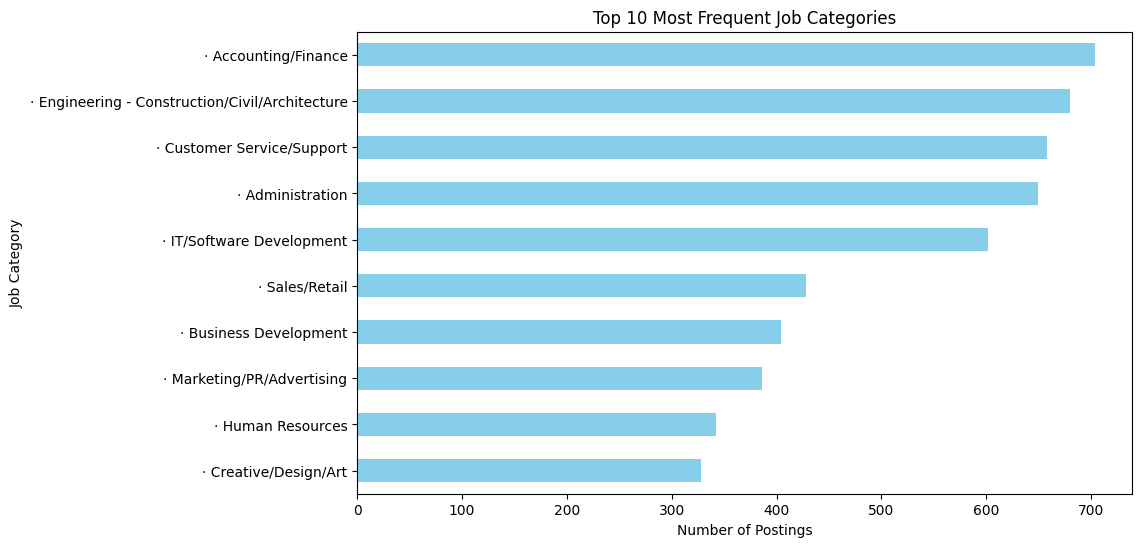

In [32]:
# Identify the most common job categories to understand market demand.
top_titles = df['Job Category'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
top_titles.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Frequent Job Categories')
plt.xlabel('Number of Postings')
plt.ylabel('Job Category')
plt.gca().invert_yaxis()  # Highest at top
plt.show()

<ipython-input-33-2a4f1cfa25c2>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




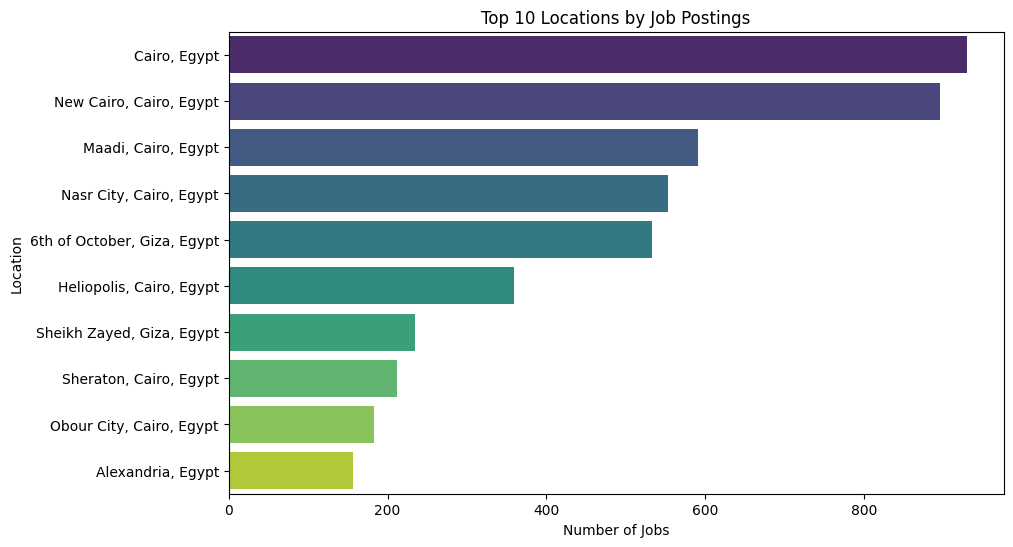

In [33]:
# Job Distribution by Location
location_counts = df['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')
plt.title('Top 10 Locations by Job Postings')
plt.xlabel('Number of Jobs')
plt.ylabel('Location')
plt.show()

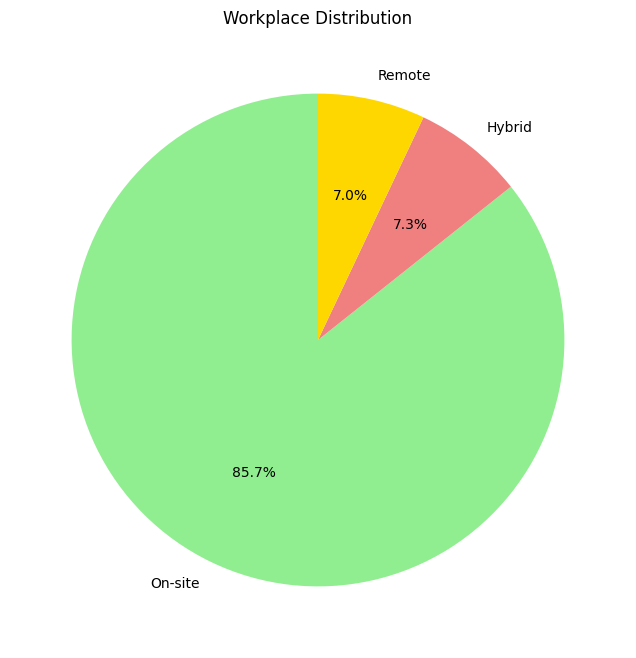

In [34]:
# Compare the prevalence of remote, hybrid, and on-site jobs.
workplace_counts = df['Workplace Type'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
workplace_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'gold'])
plt.title('Workplace Distribution')
plt.ylabel('')  # Hide y-label
plt.show()

<ipython-input-35-1d0738931f28>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




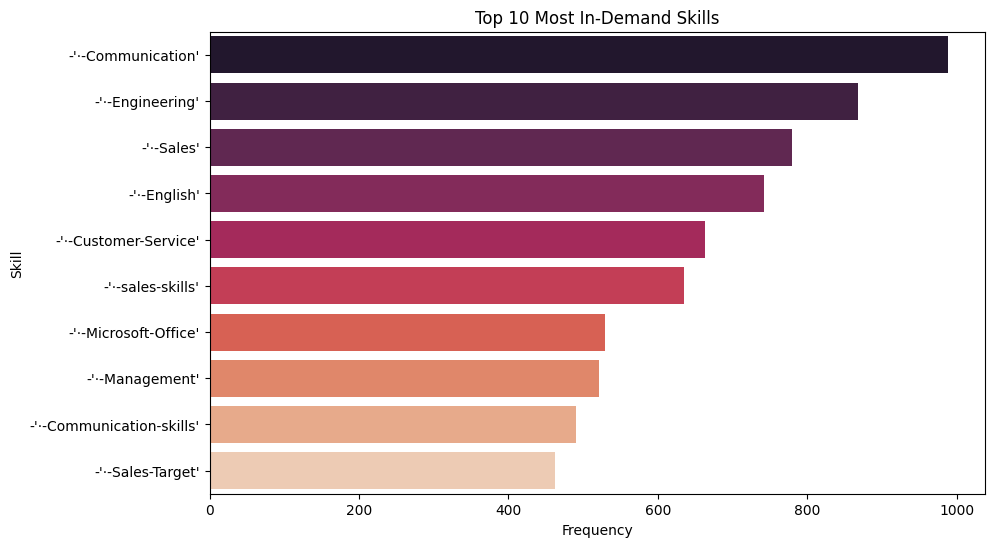

In [35]:
# Most In-Demand Skills
all_skills = df['Skills'].str.split(',').explode().str.strip()
top_skills = Counter(all_skills.dropna()).most_common(10)


plt.figure(figsize=(10, 6))
sns.barplot(x=[val[1] for val in top_skills], y=[val[0] for val in top_skills], palette='rocket')
plt.title('Top 10 Most In-Demand Skills')
plt.xlabel('Frequency')
plt.ylabel('Skill')
plt.show()